#### Unsupervided clustering methods

In this  notebook, we try multiple different methods for unsupervised clustering of the latent dim representation. We would like to find a mthod which can efficiently and accurately cluster the embedding representation. Then we use this method in conjuction with the bayesian optimization to tune the hyperparameters in our T_ME coupled autoencoder setting.

Sklearn has so many clustering and community detection algorithm that we can explore. Let see how each one of them looks like:

In [15]:
# From python
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


# From cplAE
from cplAE_MET.utils.utils import loadpkl
from cplAE_MET.utils.plots import plot_z, plot_z_3d

# Clustering and comm detection pkg
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import networkx.algorithms.community as nx_comm
from cdlib import algorithms

# Comparing different clustering results
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score

In [16]:
# Some useful functions
def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, .99
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

The following emb can be used for this study. I will be using the T representation as its distribution can't be discribed with a single gaussian

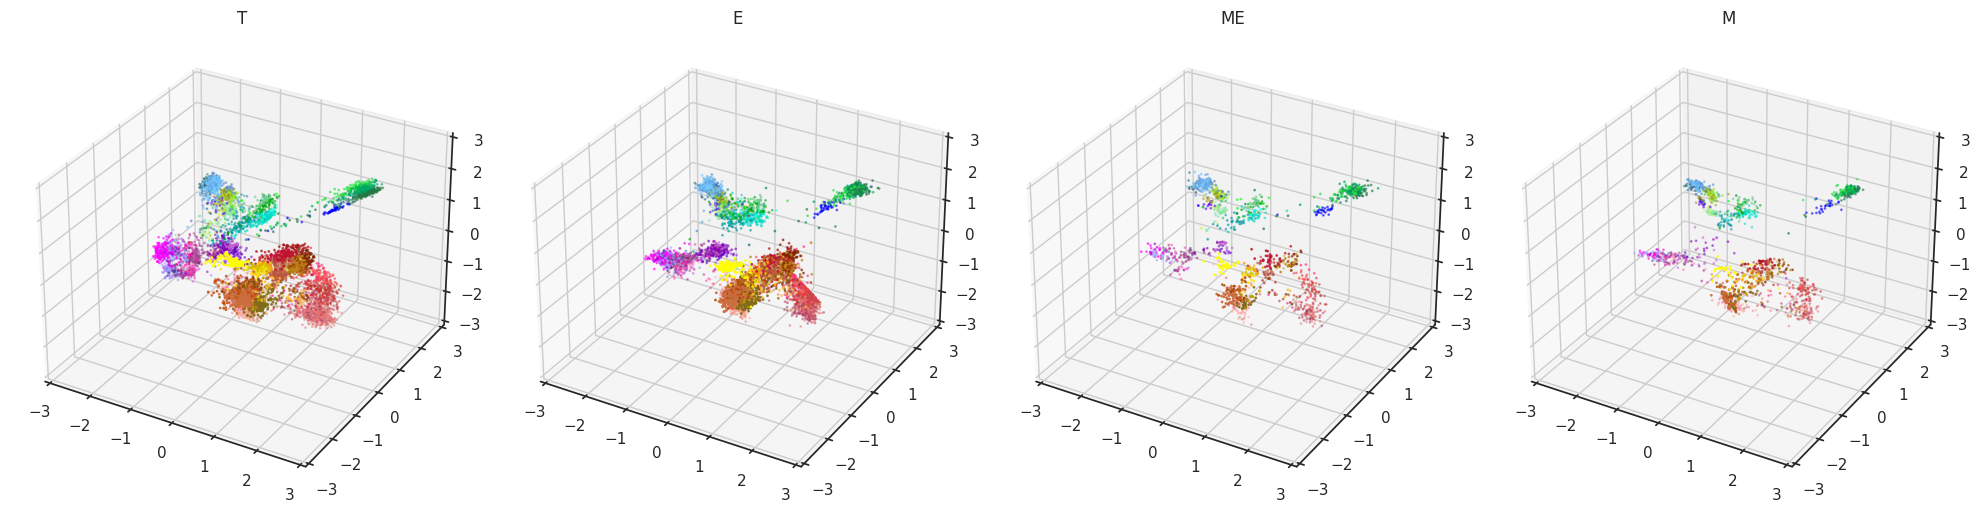

In [17]:
path ="/home/fahimehb/Local/new_codes/cplAE_MET/data/results/TEM_8643_103MNPCs_26Mfeatures_l3_v0/exit_summary_test.pkl"
output = loadpkl(path)
plot_z_3d(output, xlim=(-3, 3), ylim=(-3,3), zlim=(-3,3))

is_m_1d = output['is_m_1d']
is_e_1d = output['is_e_1d']
is_t_1d = output['is_t_1d']

is_met_1d = np.logical_and(is_t_1d, np.logical_and(is_e_1d, is_m_1d))

X = {}
colors= {}
true_labels = {}

X["t"] = output['zt'][is_t_1d]
X['me'] = output['zme_paired'][is_met_1d]
colors["t"] = output['cluster_color'][is_t_1d]
colors["me"] = output['cluster_color'][is_met_1d]
true_labels["t"] = output['cluster_label'][is_t_1d]
true_labels["me"] = output['cluster_label'][is_met_1d]


##### 1- Gaussian mixture models (unsupervised clustering)
A gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of gaussian distributions with unknown parameters. 

In [18]:
def denovo_clustering_gmm(X, n_components_range=np.arange(1,93), covariance_type="full", random_state=0, n_init=1):

    models = [GaussianMixture(n, 
                              covariance_type=covariance_type,
                              random_state=random_state, 
                              n_init=n_init, 
                              reg_covar=1e-4).fit(X) 
                        for n in n_components_range]
    return models

Lets see what will happen when we run gmm with different number of initiation. It is supposed to give us better results with higher number of n_init. 

In [40]:
for n_init in [1, 10, 20]:
    gmm_t = denovo_clustering_gmm(X["t"], n_init=n_init)
    Best_gmm_model = np.argmin([m.bic(X["t"]) for m in gmm_t])

    predictions = gmm_t[Best_gmm_model].fit(X["t"]).predict(X["t"])
    predicted_color = [get_color(p) for p in predictions]
    print(len(Counter(predictions)))

    # plot
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(X["t"][:,0], X["t"][:,1], X["t"][:,2], color=predicted_color, s=1)

    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(X["t"][:,0], X["t"][:,1], X["t"][:,2], color=colors["t"], s=1)
    plt.tight_layout()
    plt.show()


This resulted in 37, 44 and 47 clusters using n_init=1, 10 and 20. Then the jupyer notebook was restarted and the data was lost and since this is taking more than 1 hour to run, I just tried to write down the results for future reference.

#### 2 - with Bayesian Gaussian Mixture Model (unsupervised clustering )

In [ ]:
def denovo_clustering_vb_gmm(X, n_components_range=np.arange(1,93), covariance_type="full", random_state=0, n_init=1):

    models = [BayesianGaussianMixture(n_components=n, random_state=42).fit(X) for n in n_components_range]
    return models

28


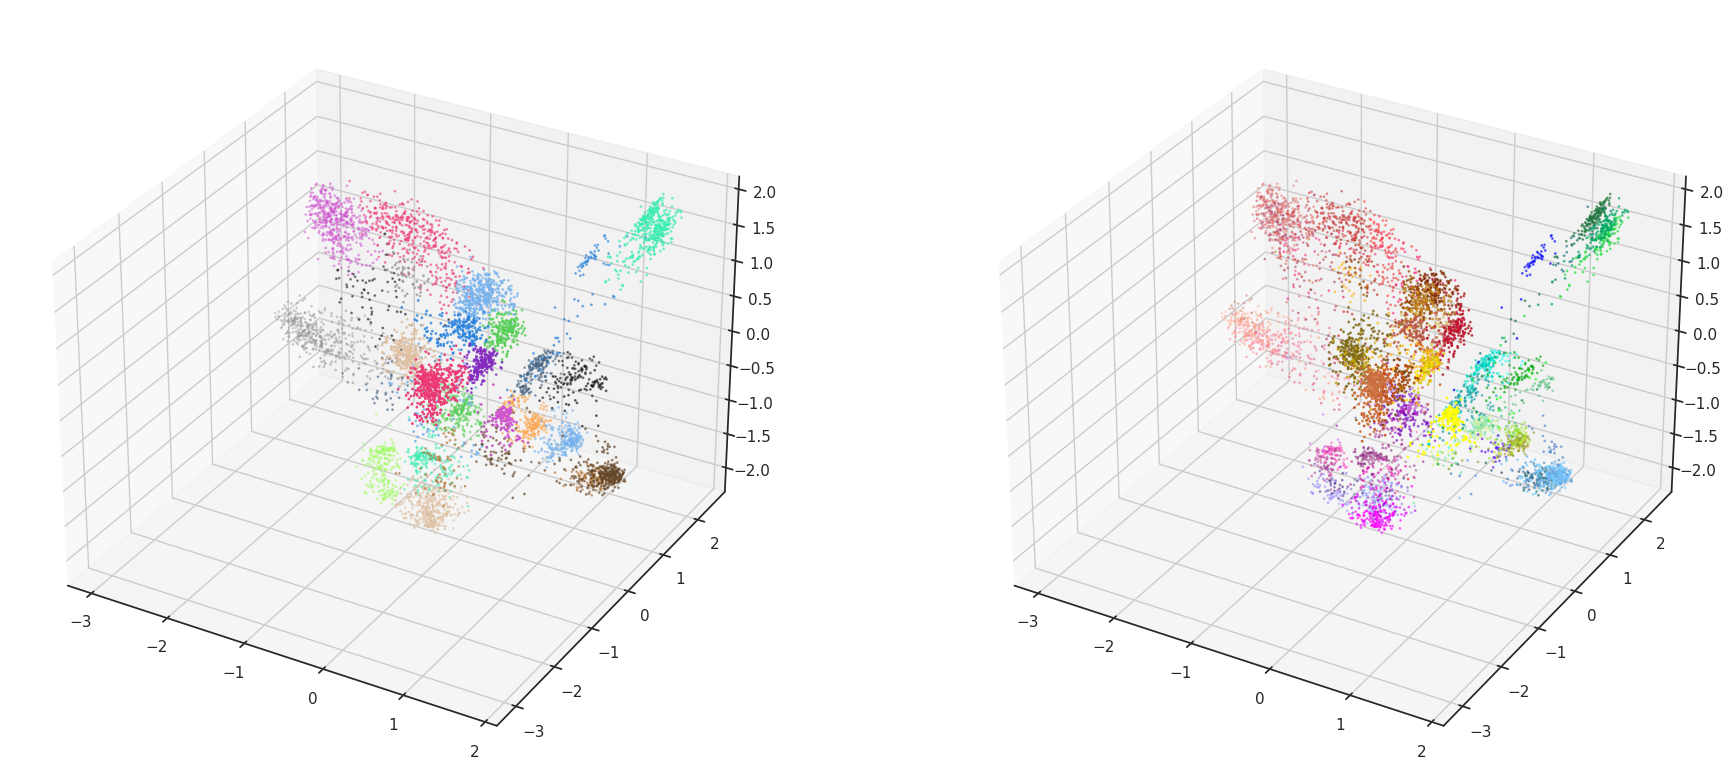

In [ ]:
for n_init in [1]:
    gmm_t_bv = denovo_clustering_vb_gmm(X["t"], n_init=n_init)
    Best_gmm_model_bv = np.argmax([m.score(X["t"]) for m in gmm_t_bv])

    predictions = gmm_t_bv[Best_gmm_model_bv].fit(X["t"]).predict(X["t"])
    predicted_color = [get_color(p) for p in predictions]
    print(len(Counter(predictions)))

    # plot
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(X["t"][:,0], X["t"][:,1], X["t"][:,2], color=predicted_color, s=1)

    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(X["t"][:,0], X["t"][:,1], X["t"][:,2], color=colors["t"], s=1)
    plt.tight_layout()
    plt.show()


### Community Detection instead of unsupervised clustering:

In [ ]:
# some useful function for community detection
def set_node_community(G, communities):
        '''Add community to node attributes'''
        for c, v_c in enumerate(communities):
            for v in v_c:
                # Add 1 to save 0 for external edges
                G.nodes[v]['community'] = c + 1
                
def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, .99
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

##### 1- Leiden Community Detection

Number of communities: 30


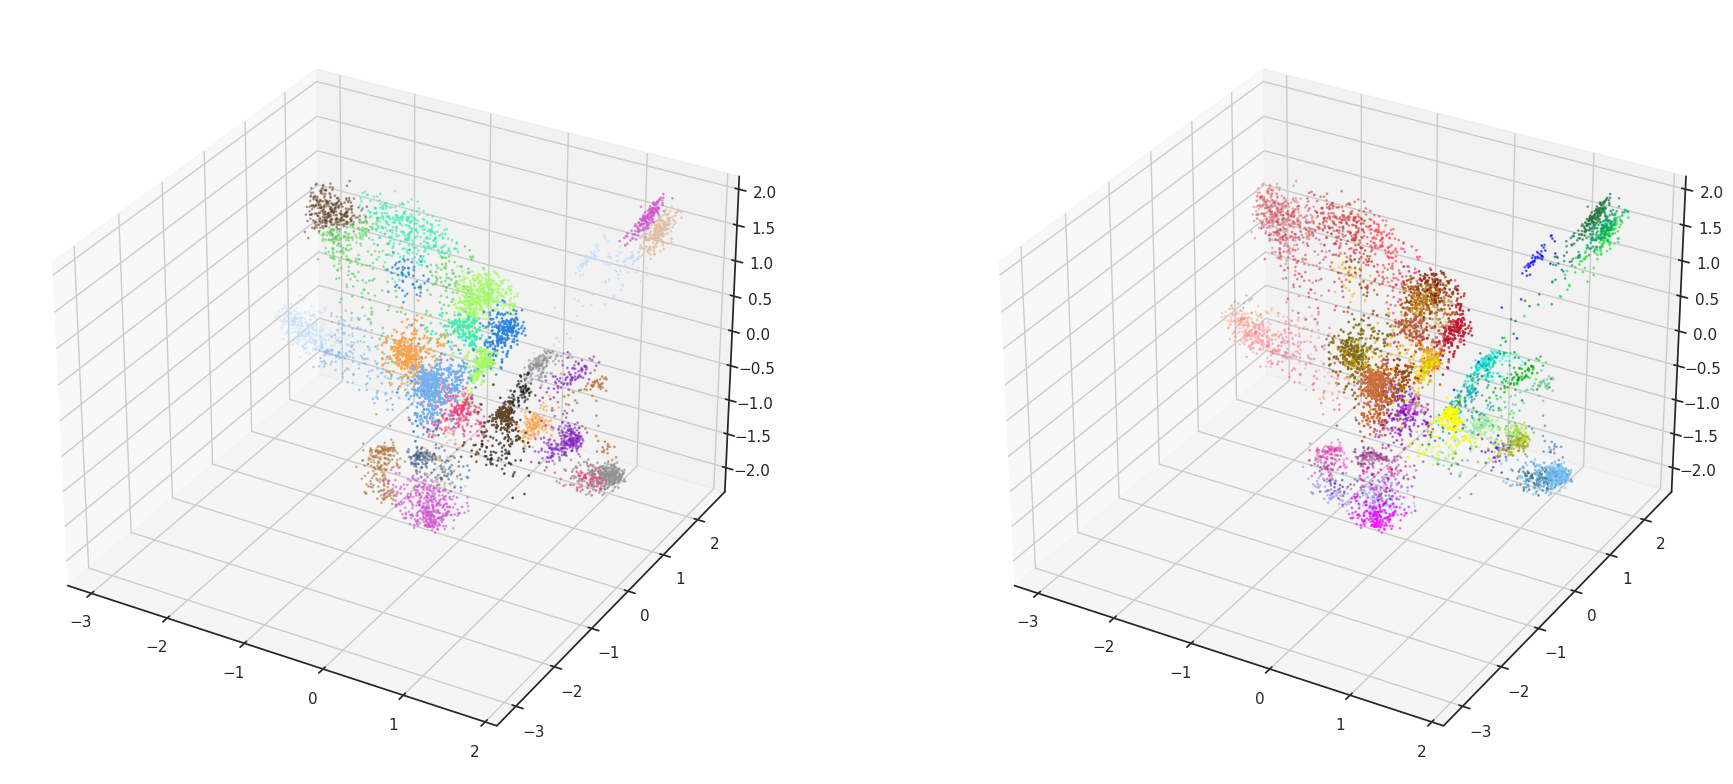

Adjusted rand score: 0.47569513097187077
Number of communities: 22


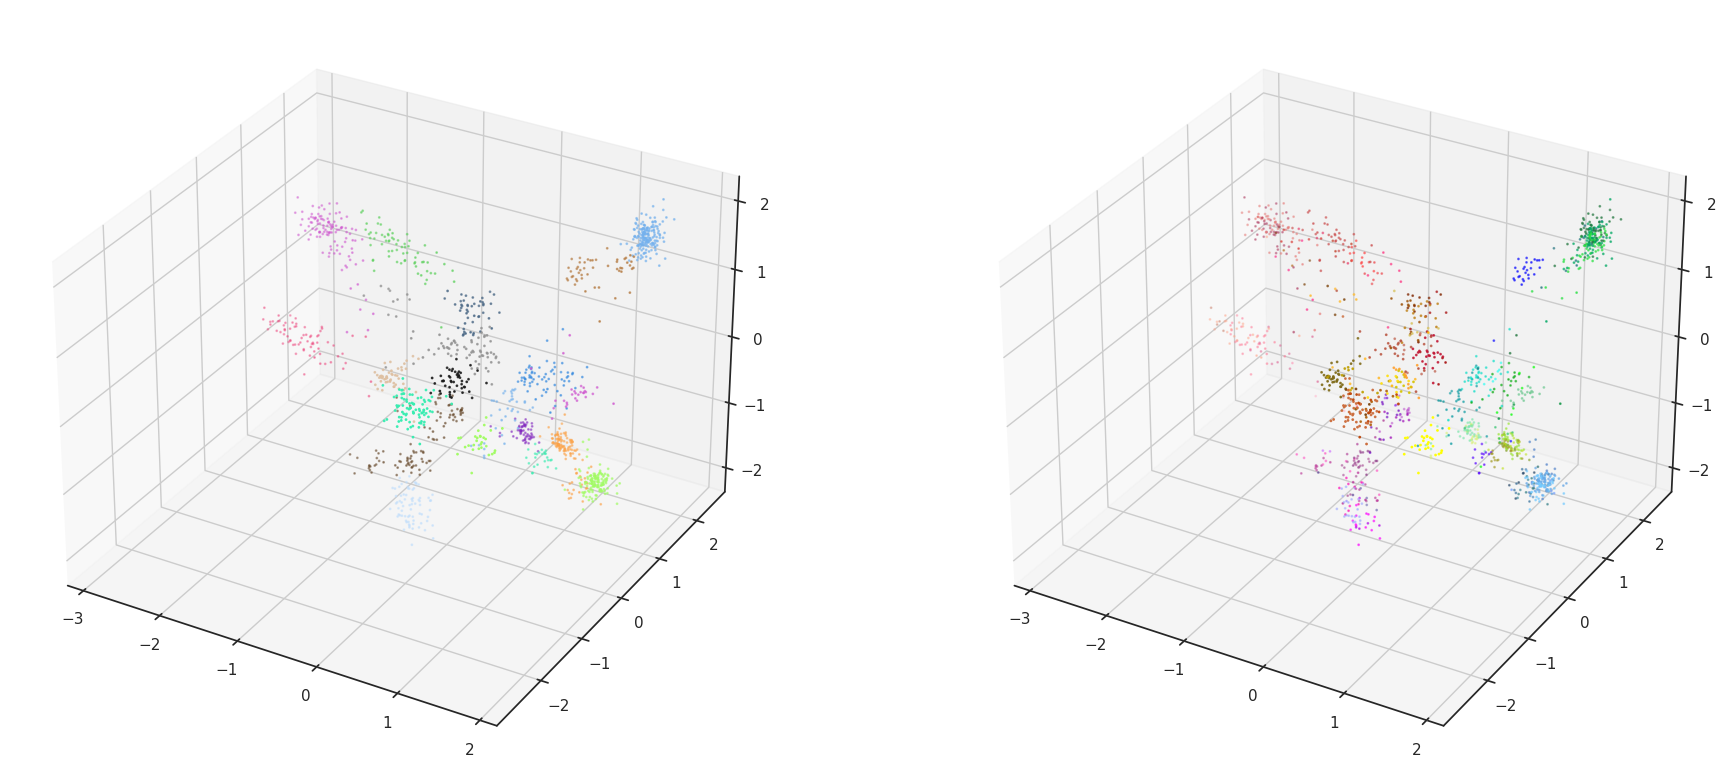

Adjusted rand score: 0.43108718911240435


In [ ]:

for data, cmap, labels in zip([X["t"], X['me']], [colors["t"], colors["me"]], [true_labels["t"], true_labels["me"]]):
    A = kneighbors_graph(data, 10, mode='distance', include_self=True)
    G = nx.convert_matrix.from_numpy_array(A)
    comm = algorithms.leiden(G)

    print("Number of communities:", len(comm.communities))
    set_node_community(G, comm.communities)
    node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]

    # plot
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(data[:,0], data[:,1], data[:,2], color=node_color, s=1)

    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(data[:,0], data[:,1], data[:,2], color=cmap, s=1)
    plt.tight_layout()
    plt.show()

    predicted_labels = [G.nodes[i]['community'] for i in range(len(G.nodes))]
    print("Adjusted rand score:", adjusted_rand_score(labels, predicted_labels))


Number of communities: 27


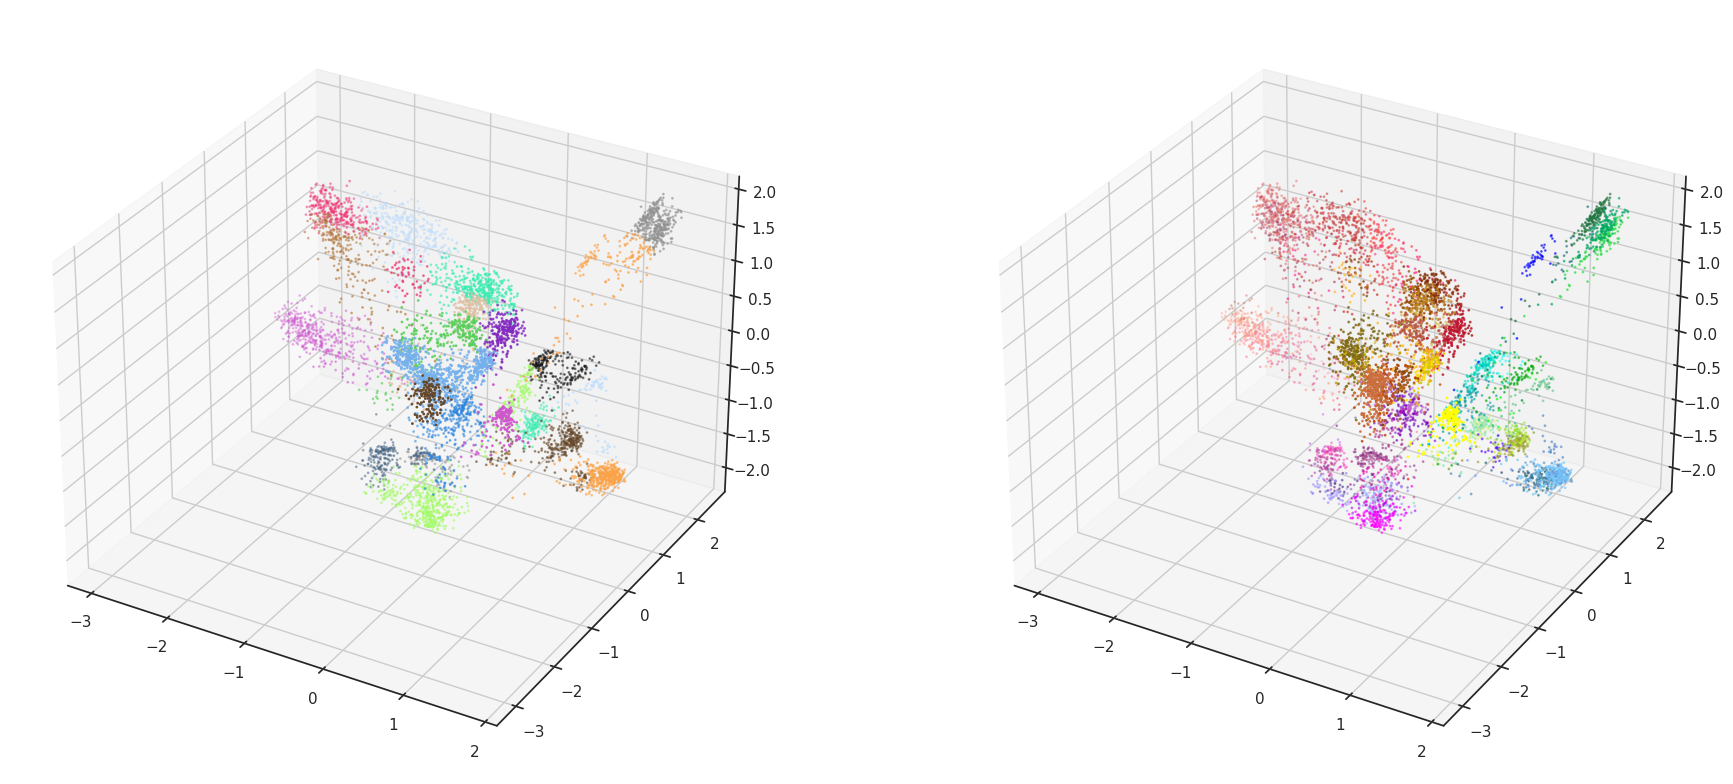

Adjusted rand score: 0.376743771016521
Number of communities: 21


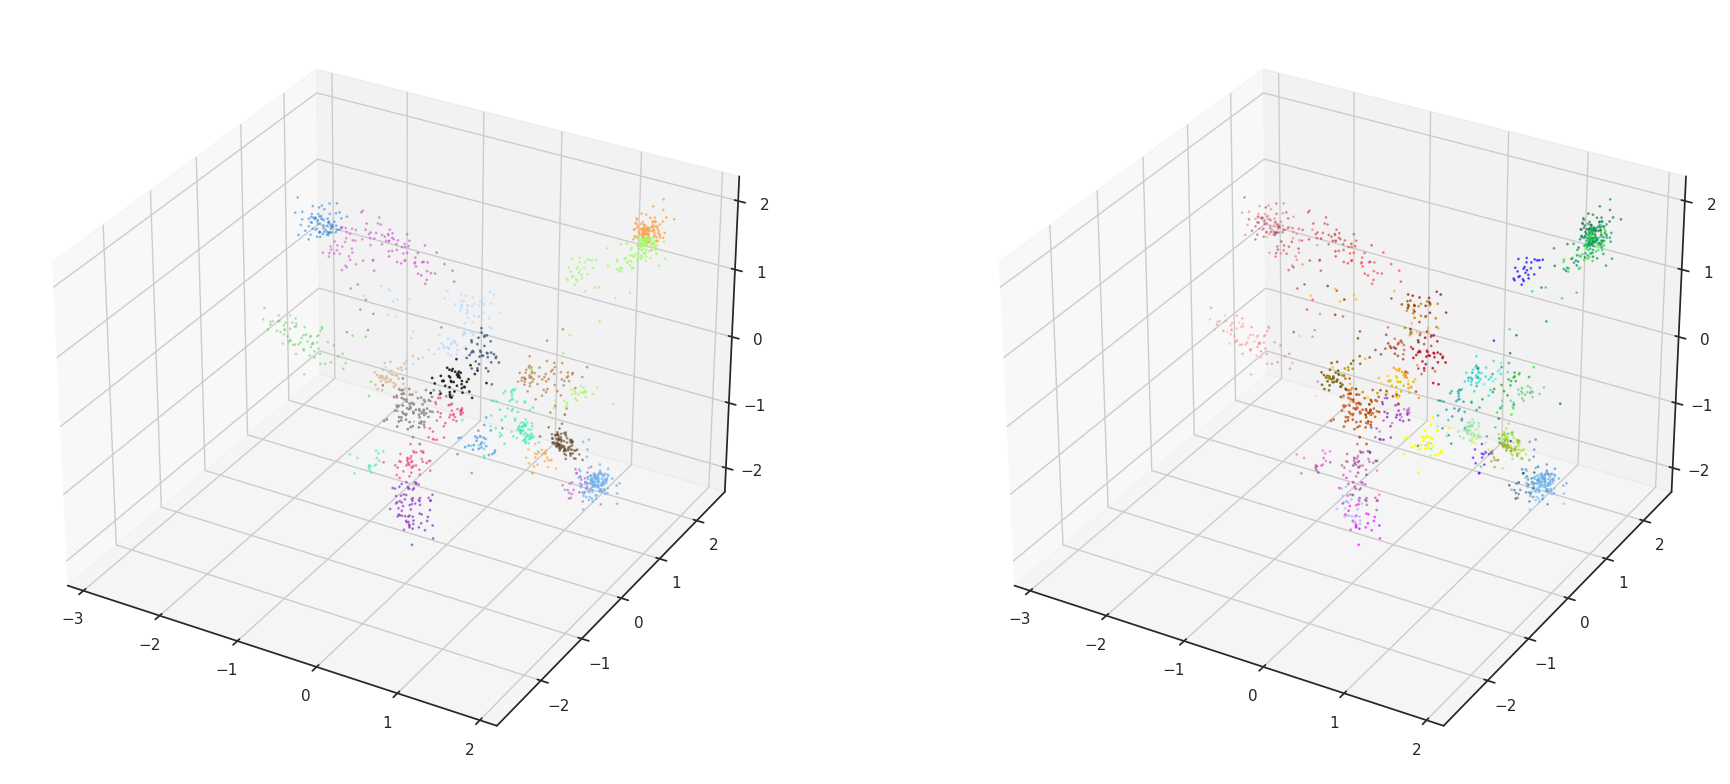

Adjusted rand score: 0.38786108663873603


In [ ]:

for data, cmap, labels in zip([X["t"], X['me']], [colors["t"], colors["me"]], [true_labels["t"], true_labels["me"]]):
    A = kneighbors_graph(data, 10, mode='distance', include_self=False)
    G = nx.convert_matrix.from_numpy_array(A)
    comm = algorithms.louvain(G)

    print("Number of communities:", len(comm.communities))
    set_node_community(G, comm.communities)
    node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]

    # plot
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(data[:,0], data[:,1], data[:,2], color=node_color, s=1)

    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(data[:,0], data[:,1], data[:,2], color=cmap, s=1)
    plt.tight_layout()
    plt.show()

    predicted_labels = [G.nodes[i]['community'] for i in range(len(G.nodes))]
    print("Adjusted rand score:", adjusted_rand_score(labels, predicted_labels))



### Greedy Modularity communities

7


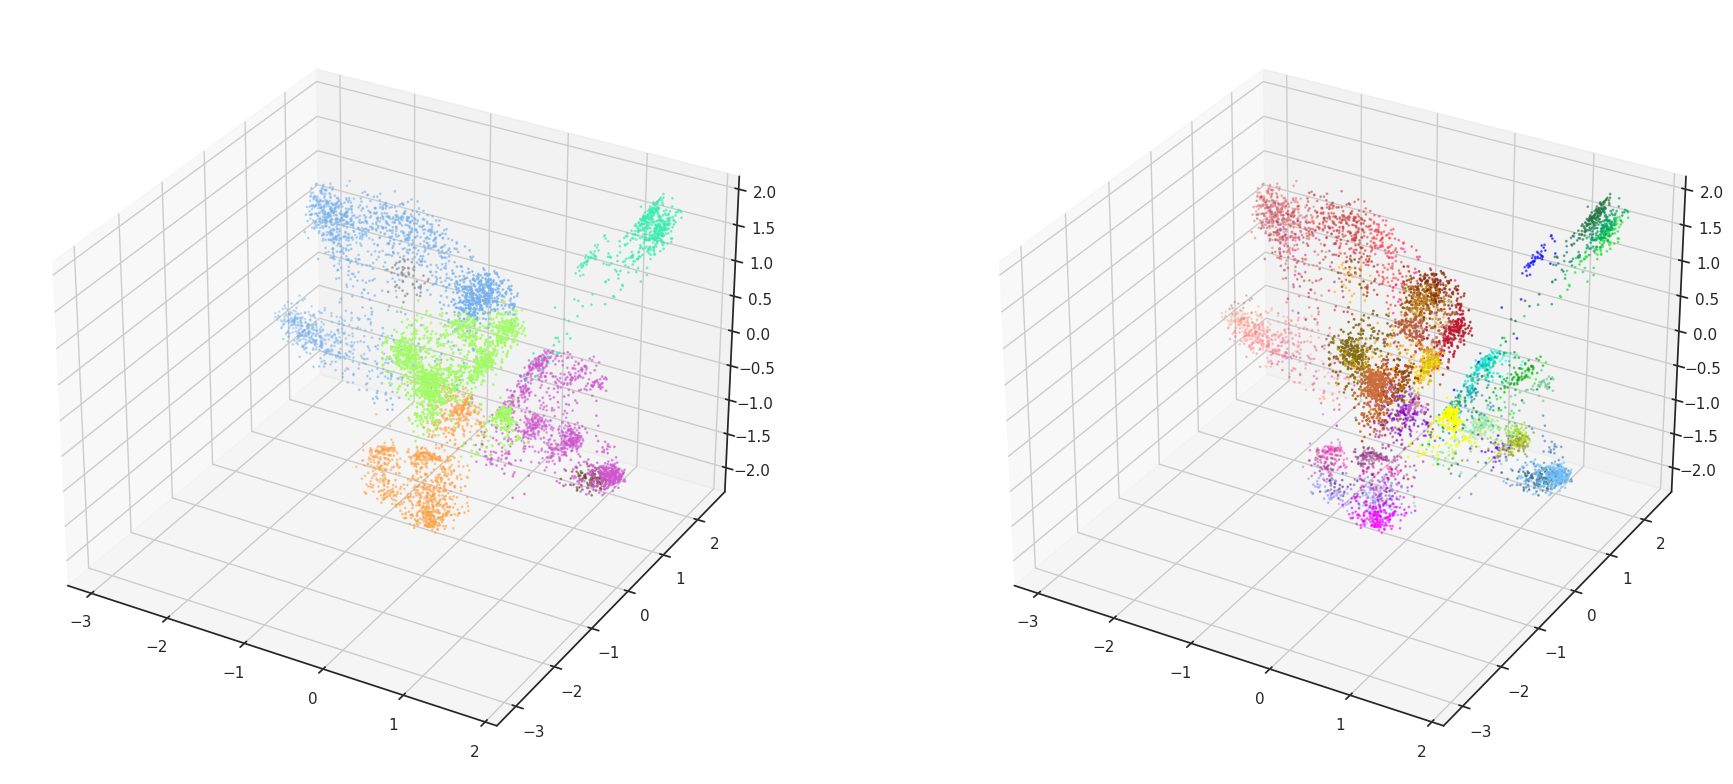

In [ ]:
#Detect communities
comm = nx_comm.greedy_modularity_communities(G)
print(len(comm))
set_node_community(G, comm)
node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]

# plot
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], color=node_color, s=1)

ax = fig.add_subplot(122, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], color=colors, s=1)
plt.tight_layout()
plt.show()

Visualizing the clusters is not enough to decide which method should be used. Therefore I am going to use a metric called "Adjusted Rand Score" to decide which clustering or community detection algorithm I like better. Adjusted Rand Score measure the amount of overlap a community detection result has with ground truth. The closer this number is to 1, the better is the method.

#### Adjusted Rand Index

In [25]:
results = []
for data, cmap, labels, mode in zip([X["t"], X["me"]],
                                    [colors["t"], colors['me']],
                                    [true_labels["t"], true_labels["me"]], 
                                    ["T", "ME"]):
    for algo, platform in zip([algorithms.leiden, algorithms.louvain], 
                              ["Leiden", "Louvain"]):
        nc = []
        nearn = []
        ARS = []
        MIS = []
        for nn in [5, 8, 10, 12, 15, 18, 20]:
            nearn.append(nn)
            A = kneighbors_graph(data, nn, mode='distance', include_self=True)
            G = nx.convert_matrix.from_numpy_array(A)
            comm = algo(G)

            ncomm = len(comm.communities)
            nc.append(ncomm)
            set_node_community(G, comm.communities)

            predicted_labels = [G.nodes[i]['community'] for i in range(len(G.nodes))]
            score = adjusted_mutual_info_score(labels, predicted_labels)
            MIS.append(score)
            score = adjusted_rand_score(labels, predicted_labels)
            ARS.append(score)

        results.append(pd.DataFrame({"nc": nc,
                                "nn": nearn, 
                                "Adjusted_Rand_Score":ARS,
                                "Adjusted_MI_score": MIS, 
                                "Method": platform, 
                                "modality":mode}))

results = pd.concat(results)

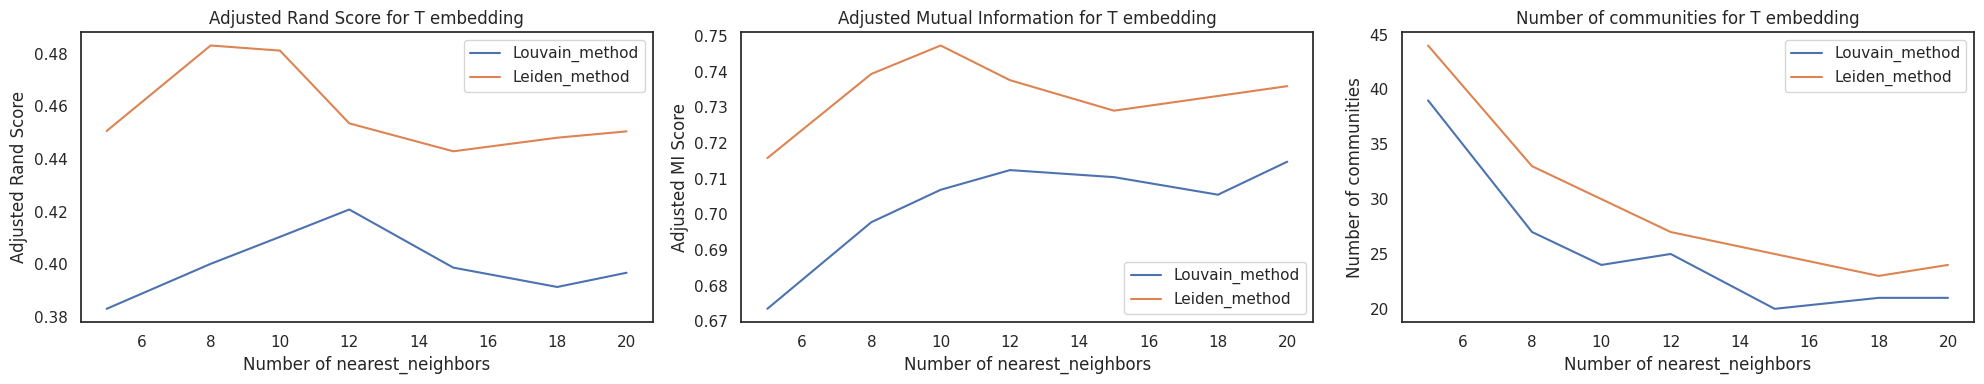

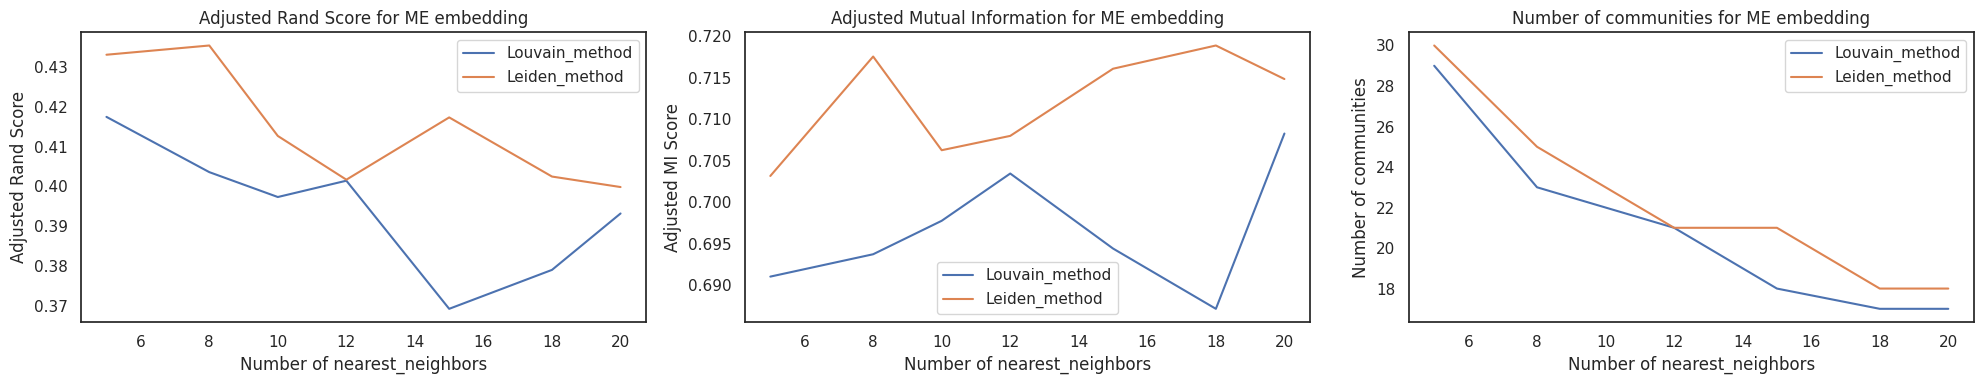

In [39]:
# plot
for mode in ["T", "ME"]:
    df = results[results['modality']==mode]
    fig = plt.figure(figsize=(20,4))
    ax = fig.add_subplot(131)
    ax.set_title(f"Adjusted Rand Score for {mode} embedding")
    ax.plot(df[df['Method']=='Louvain']['nn'], df[df['Method']=='Louvain']["Adjusted_Rand_Score"], label="Louvain_method")
    ax.plot(df[df['Method']=='Leiden']['nn'], df[df['Method']=='Leiden']["Adjusted_Rand_Score"], label="Leiden_method")
    ax.set_xlabel("Number of nearest_neighbors")
    ax.set_ylabel("Adjusted Rand Score")
    plt.legend()

    ax = fig.add_subplot(132)
    ax.set_title(f"Adjusted Mutual Information for {mode} embedding")
    ax.plot(df[df['Method']=='Louvain']['nn'], df[df['Method']=='Louvain']["Adjusted_MI_score"], label="Louvain_method")
    ax.plot(df[df['Method']=='Leiden']['nn'], df[df['Method']=='Leiden']["Adjusted_MI_score"], label="Leiden_method")
    ax.set_xlabel("Number of nearest_neighbors")
    ax.set_ylabel("Adjusted MI Score")
    plt.legend()

    ax = fig.add_subplot(133)
    ax.set_title(f"Number of communities for {mode} embedding")
    ax.plot(df[df['Method']=='Louvain']['nn'], df[df['Method']=='Louvain']["nc"], label="Louvain_method")
    ax.plot(df[df['Method']=='Leiden']['nn'], df[df['Method']=='Leiden']["nc"], label="Leiden_method")
    ax.set_xlabel("Number of nearest_neighbors")
    ax.set_ylabel("Number of communities")
    plt.tight_layout()
    plt.legend()
    plt.show()

I compared GMM clustering with Louvain and Leiden community detection. At the end, I decided against using GMM just becasue it was much slower to perfrom. Between Louvain and Leiden, it seems that Leiden is doing a better job in clusetring. I used different number of k nearest neighbors to construct the graph (namely: 5, 8, 10, 12, 15, 18 and 20). To see which method and what number of knn gives the best results, I looked at the predicted clusters and compared them to the original ground truth labels we had for transcritomic. I used Adjusted Rand Index and Adjusted Mutual information scores as metrics. Overall, Leiden is doing a better job as you can see that the orange line is above the blue line in all the plots. I am not sure, how many knn is really the optimized but maybe 8, 10 or 12 is good enough (also looking at the number of communities). 